<a href="https://colab.research.google.com/github/Constantinodd/Jupyter-notebook.ipynb/blob/main/RedesConvolucionais.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
import matplotlib.pyplot as plt
import os

from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from torchvision.datasets import CIFAR10

In [3]:
BASE_DIR = '/content/drive/MyDrive/Colab Notebooks/mydrive'
DATA_DIR = '/content/drive/MyDrive/Colab Notebooks/mydrive'
CATEGORIES = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
def get_path(relpath):
  return os.path.join(BASE_DIR, relpath)

In [4]:
cifar10_train = CIFAR10(DATA_DIR, train=True, download=True)
cifar10_test = CIFAR10(DATA_DIR, train=False, download=True)

In [5]:

(len(cifar10_train), len(cifar10_test))

(50000, 10000)

In [6]:
def lookat_dataset(dataset, istensor=False):
  figure = plt.figure(figsize=(8, 8))
  rows, cols = 2, 2
  for i in range(1, 5):
      sample_idx = torch.randint(len(dataset), size=(1,)).item()
      img, label = dataset[sample_idx]
      figure.add_subplot(rows, cols, i)
      plt.title(CATEGORIES[label])
      plt.axis("off")
      if istensor:
        plt.imshow(img.squeeze().permute(1, 2, 0))
      else:
        plt.imshow(img)
  plt.show()

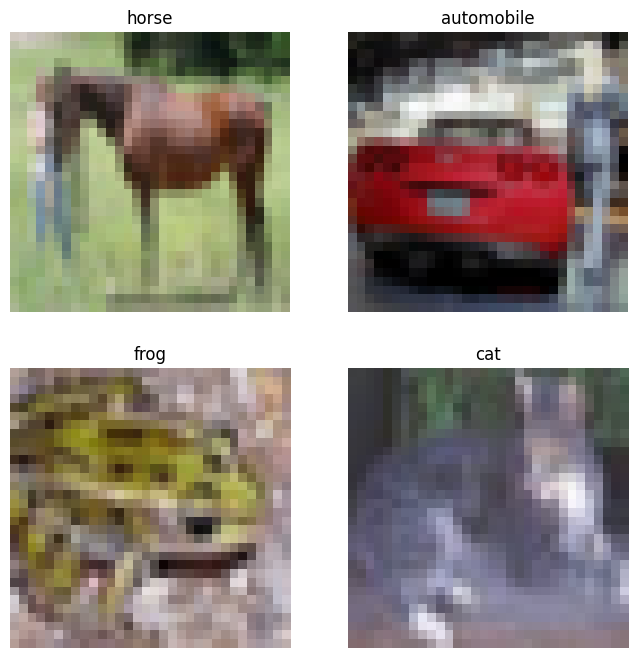

In [7]:
lookat_dataset(cifar10_train)

In [8]:
prep_transform = T.Compose([
                    T.ToTensor(),
                    T.Normalize(
                        (0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)
                    )
                  ])

# Applying a transform
tensor_train = CIFAR10(DATA_DIR, train=True, download=False,
                         transform=prep_transform)
tensor_test = CIFAR10(DATA_DIR, train=False, download=False,
                         transform=prep_transform)

In [9]:
# Normalizing data
imgs = torch.stack([img_t for img_t, _ in tensor_train], dim=3)
imgs.shape

torch.Size([3, 32, 32, 50000])

In [10]:

imgs.view(3, -1).mean(dim=1)

tensor([-1.2762e-06, -1.7074e-04,  1.1819e-04])

In [11]:

imgs.view(3, -1).std(dim=1)

tensor([1.0001, 0.9999, 1.0000])

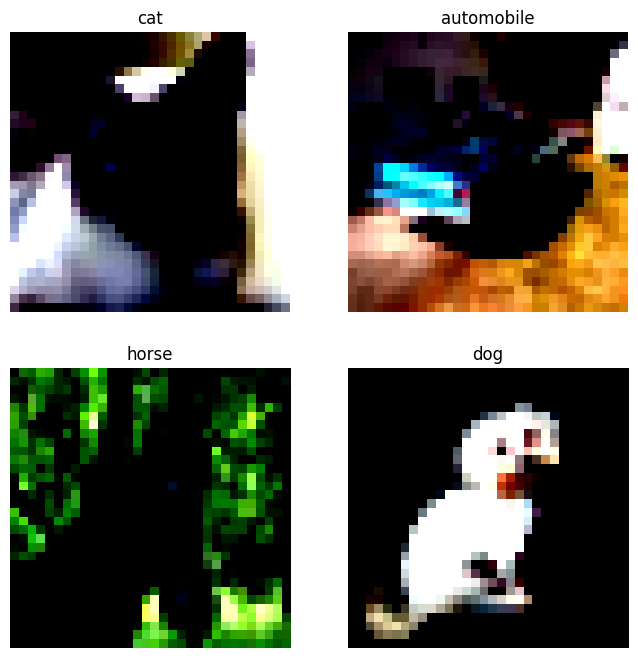

In [12]:

lookat_dataset(tensor_train, True)

In [13]:
batch_size = 64
train_loader = DataLoader(tensor_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(tensor_test, batch_size=batch_size, shuffle=False)

In [14]:
from torch import nn

In [15]:
class MLPClassifier(nn.Module):
  def __init__(self):
    super().__init__()
    self.flatten = nn.Flatten()

    self.layers = nn.Sequential(
        nn.Linear(3 * 32*32, 256),
        nn.ReLU(),
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Linear(64, 10),
    )

  def forward(self, x):
    v = self.flatten(x)
    return self.layers(v)

In [16]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Rodando na {device}")

Rodando na cuda


In [17]:
model = MLPClassifier().to(device)

In [18]:
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [19]:
def train(model, dataloader, loss_func, optimizer):
  model.train()
  cumloss = 0.0

  for imgs, labels in dataloader:
    imgs, labels = imgs.to(device), labels.to(device)

    optimizer.zero_grad()

    pred = model(imgs)

    loss = loss_func(pred, labels)
    loss.backward()
    optimizer.step()

    cumloss += loss.item()

  return cumloss / len(dataloader)

def validate(model, dataloader, loss_func):
  model.eval()
  cumloss = 0.0

  with torch.no_grad():
    for imgs, labels in dataloader:
      imgs, labels = imgs.to(device), labels.to(device)

      pred = model(imgs)
      loss = loss_func(pred, labels)
      cumloss += loss.item()

  return cumloss / len(dataloader)

In [20]:
def plot_losses(losses):
  fig = plt.figure(figsize=(13, 5))
  ax = fig.gca()
  for loss_name, loss_values in losses.items():
    ax.plot(loss_values, label=loss_name)
  ax.legend(fontsize="16")
  ax.set_xlabel("Iteration", fontsize="16")
  ax.set_ylabel("Loss", fontsize="16")
  ax.set_title("Loss vs iterations", fontsize="16");

In [21]:
epochs = 41
train_losses = []
test_losses = []
for t in range(epochs):
  train_loss = train(model, train_loader, loss_func, optimizer)
  train_losses.append(train_loss)
  if t % 10 == 0:
    print(f"Epoch: {t}; Train Loss: {train_loss}")

  test_loss = validate(model, test_loader, loss_func)
  test_losses.append(test_loss)

Epoch: 0; Train Loss: 2.297893051601127
Epoch: 10; Train Loss: 1.8597430006012587
Epoch: 20; Train Loss: 1.6479991951866833
Epoch: 30; Train Loss: 1.522605651022528
Epoch: 40; Train Loss: 1.4168328592539443


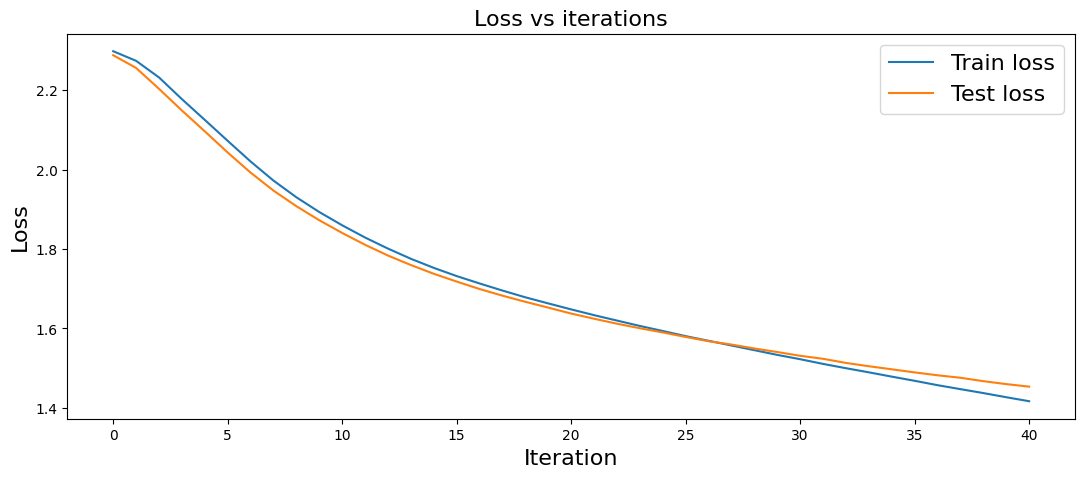

In [22]:
losses = {"Train loss": train_losses, "Test loss": test_losses}
plot_losses(losses)

In [23]:
def make_confusion_matrix(model, loader, n_classes):
  confusion_matrix = torch.zeros(n_classes, n_classes, dtype=torch.int64)
  with torch.no_grad():
    for i, (imgs, labels) in enumerate(loader):
      imgs = imgs.to(device)
      labels = labels.to(device)
      outputs = model(imgs)
      _, predicted = torch.max(outputs, 1)
      for t, p in zip(torch.as_tensor(labels, dtype=torch.int64).view(-1),
                      torch.as_tensor(predicted, dtype=torch.int64).view(-1)):
        confusion_matrix[t, p] += 1
  return confusion_matrix

def evaluate_accuracy(model, dataloader, classes, verbose=True):
  # prepare to count predictions for each class
  correct_pred = {classname: 0 for classname in classes}
  total_pred = {classname: 0 for classname in classes}

  confusion_matrix = make_confusion_matrix(model, dataloader, len(classes))
  if verbose:
    total_correct = 0.0
    total_prediction = 0.0
    for i, classname in enumerate(classes):
      correct_count = confusion_matrix[i][i].item()
      class_pred = torch.sum(confusion_matrix[i]).item()

      total_correct += correct_count
      total_prediction += class_pred

      accuracy = 100 * float(correct_count) / class_pred
      print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                    accuracy))
  print("Global acccuracy is {:.1f}".format(100 * total_correct/total_prediction))
  return confusion_matrix

def test(model, dataloader, classes):
  # prepare to count predictions for each class
  correct_pred = {classname: 0 for classname in classes}
  total_pred = {classname: 0 for classname in classes}

  # again no gradients needed
  with torch.no_grad():
      for images, labels in dataloader:
          images, labels = images.to(device), labels.to(device)
          outputs = model(images)
          _, predictions = torch.max(outputs, 1)
          # collect the correct predictions for each class
          for label, prediction in zip(labels, predictions):
              if label == prediction:
                  correct_pred[classes[label]] += 1
              total_pred[classes[label]] += 1

  # print accuracy for each class
  total_correct = 0.0
  total_prediction = 0.0
  for classname, correct_count in correct_pred.items():
      total_correct += correct_count
      total_prediction += total_pred[classname]
      accuracy = 100 * float(correct_count) / total_pred[classname]
      print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                    accuracy))
  print("Global acccuracy is {:.1f}".format(100 * total_correct/total_prediction))

In [24]:
confusion_matrix = evaluate_accuracy(model, test_loader, CATEGORIES)

Accuracy for class airplane is: 52.9 %
Accuracy for class automobile is: 63.0 %
Accuracy for class bird  is: 33.2 %
Accuracy for class cat   is: 34.5 %
Accuracy for class deer  is: 34.3 %
Accuracy for class dog   is: 36.0 %
Accuracy for class frog  is: 57.4 %
Accuracy for class horse is: 58.5 %
Accuracy for class ship  is: 66.7 %
Accuracy for class truck is: 50.9 %
Global acccuracy is 48.7


In [25]:
import seaborn as sn

<Axes: >

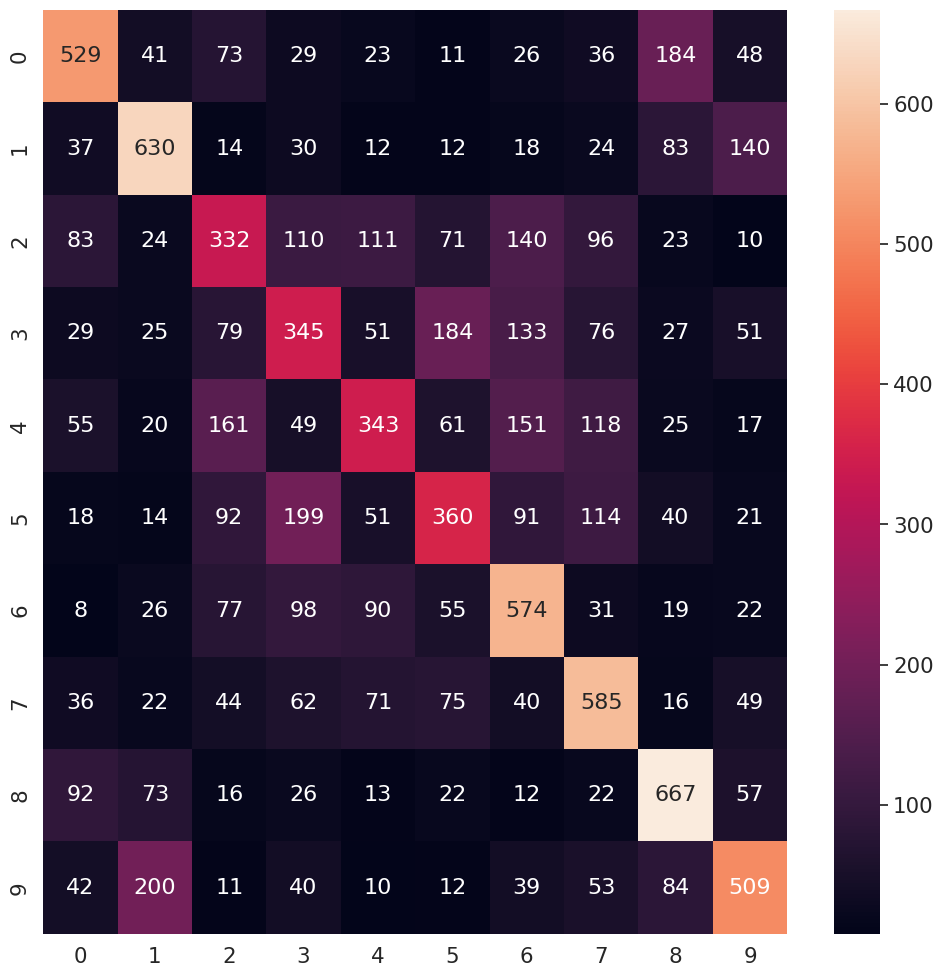

In [26]:
plt.figure(figsize=(12, 12))
sn.set(font_scale=1.4)
sn.heatmap(confusion_matrix.tolist(),
           annot=True, annot_kws={"size": 16}, fmt='d')

In [27]:
class ConvolutionalModel(nn.Module):
  def __init__(self):
      super().__init__()
      self.convlayers = nn.Sequential(
        nn.Conv2d(3, 16, kernel_size=(3, 3)),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),

        nn.Conv2d(16, 32, kernel_size=(3, 3)),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),

      )

      self.linearlayers = nn.Sequential(
          nn.Linear(1152, 256),
          nn.ReLU(),
          nn.Linear(256, 10)
      )

  def forward(self, x):
      x = self.convlayers(x)
      x = torch.flatten(x, 1)
      return self.linearlayers(x)

In [28]:
convmodel = ConvolutionalModel().to(device)

In [29]:
loss_func2 = nn.CrossEntropyLoss()
optimizer2 = torch.optim.SGD(convmodel.parameters(), lr=0.001)

In [30]:
epochs = 51
conv_train_losses = []
conv_test_losses = []
for t in range(epochs):
  train_loss = train(convmodel, train_loader, loss_func2, optimizer2)
  conv_train_losses.append(train_loss)
  if t % 10 == 0:
    print(f"Epoch: {t}; Train Loss: {train_loss}")
  test_loss = validate(convmodel, test_loader, loss_func2)
  conv_test_losses.append(test_loss)

Epoch: 0; Train Loss: 2.288690124631233
Epoch: 10; Train Loss: 1.6916069482903346
Epoch: 20; Train Loss: 1.4097607387301256
Epoch: 30; Train Loss: 1.2869556152149844
Epoch: 40; Train Loss: 1.1927508062413892
Epoch: 50; Train Loss: 1.1091982208554396


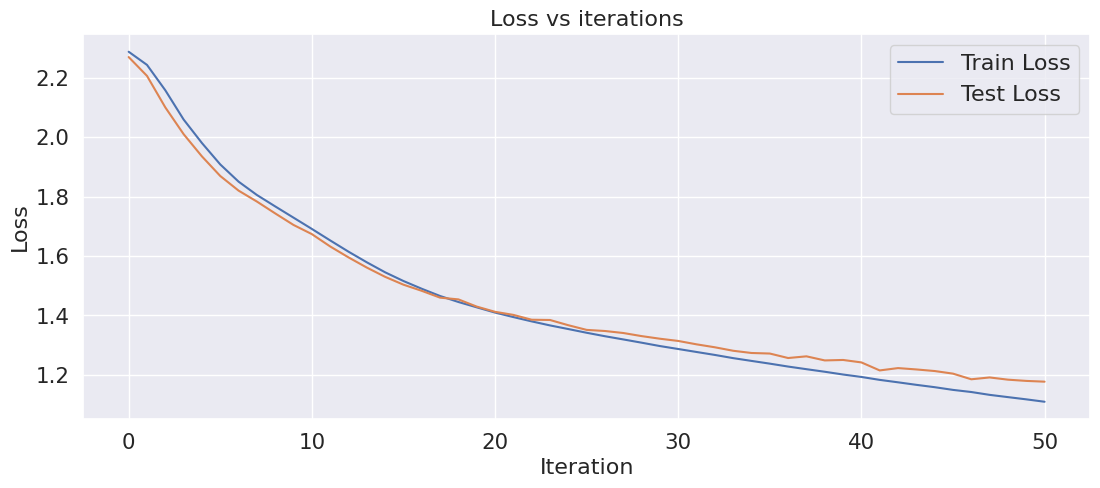

In [31]:
conv_losses = {"Train Loss": conv_train_losses, "Test Loss": conv_test_losses}
plot_losses(conv_losses)


In [32]:
conv_confusion_matrix = evaluate_accuracy(convmodel, test_loader, CATEGORIES)

Accuracy for class airplane is: 66.5 %
Accuracy for class automobile is: 63.2 %
Accuracy for class bird  is: 34.1 %
Accuracy for class cat   is: 40.7 %
Accuracy for class deer  is: 52.6 %
Accuracy for class dog   is: 46.1 %
Accuracy for class frog  is: 80.2 %
Accuracy for class horse is: 56.8 %
Accuracy for class ship  is: 77.7 %
Accuracy for class truck is: 67.1 %
Global acccuracy is 58.5


<Axes: >

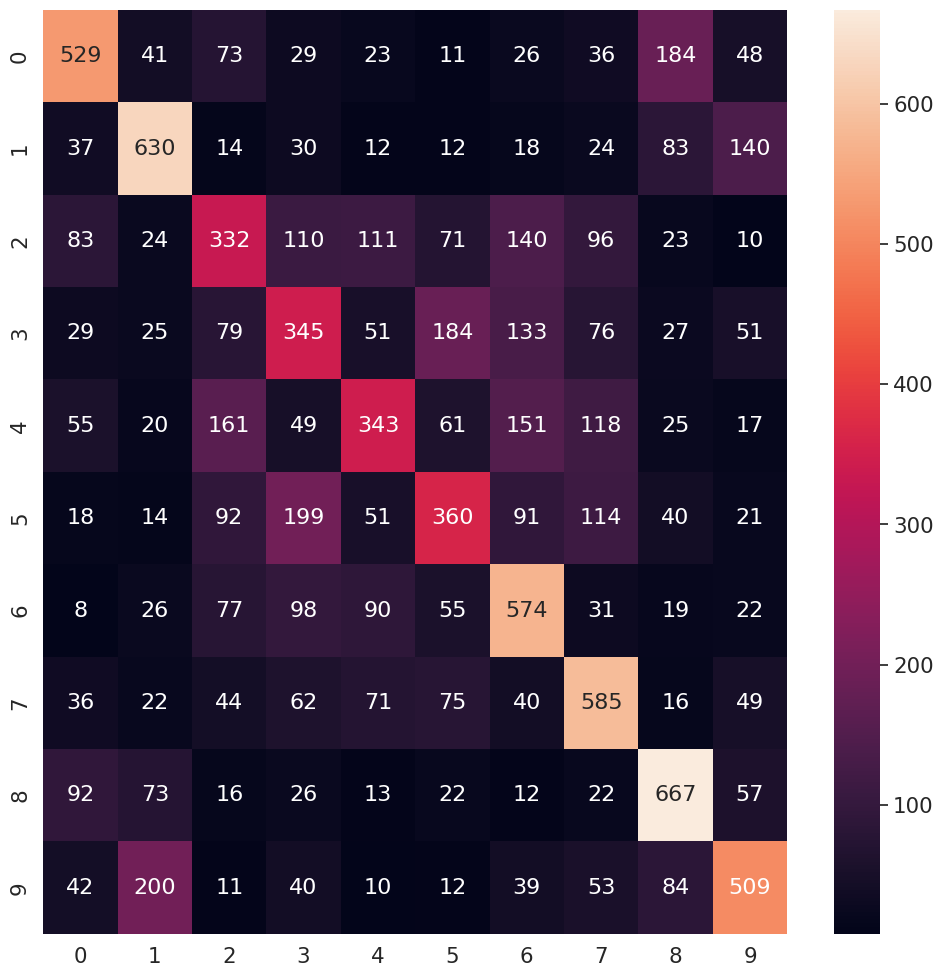

In [33]:
plt.figure(figsize=(12, 12))
sn.set(font_scale=1.4)
sn.heatmap(confusion_matrix.tolist(),
           annot=True, annot_kws={"size": 16}, fmt='d')

In [34]:

from PIL import Image

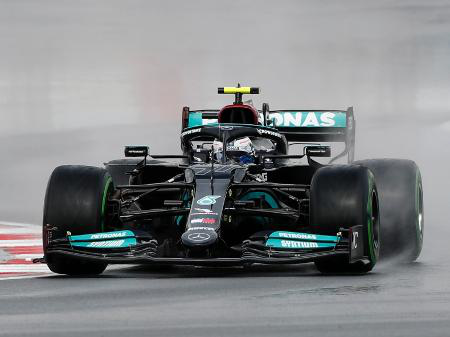

In [35]:
img = Image.open(get_path('/content/drive/MyDrive/carrof1.jpeg'))
img

In [36]:
prep_transforms = T.Compose(
    [T.Resize((32, 32)),
     T.ToTensor(),
     T.Normalize( (0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616) )
     ]
)
img_tensor = prep_transforms(img)

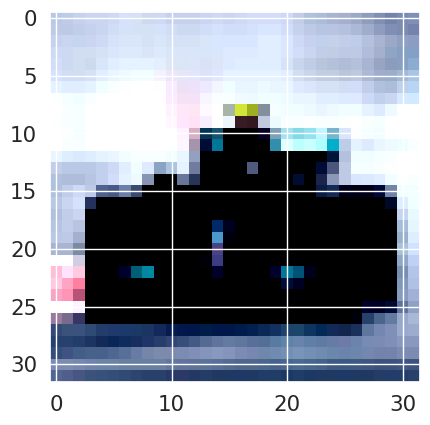

In [37]:
plt.imshow(img_tensor.permute(1,2, 0))

In [38]:
batch = img_tensor.unsqueeze(0).to(device)

In [39]:

convmodel.eval()

ConvolutionalModel(
  (convlayers): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linearlayers): Sequential(
    (0): Linear(in_features=1152, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=10, bias=True)
  )
)

In [40]:
output = convmodel(batch)
output


tensor([[ 0.6386,  4.0410, -1.6041,  0.2555, -0.2876, -2.0556,  0.2386, -2.3216,
          0.8901,  3.6439]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [41]:
logits = torch.nn.functional.softmax(output, dim=1) * 100
prob_dict = {}
for i, classname in enumerate(CATEGORIES):
  prob = logits[0][i].item()
  print(f"{classname} score: {prob:.2f}")
  prob_dict[classname] = [prob]

airplane score: 1.84
automobile score: 55.12
bird score: 0.19
cat score: 1.25
deer score: 0.73
dog score: 0.12
frog score: 1.23
horse score: 0.10
ship score: 2.36
truck score: 37.06


In [42]:
import pandas as pd

In [43]:
df_prob = pd.DataFrame.from_dict(prob_dict)

<Axes: >

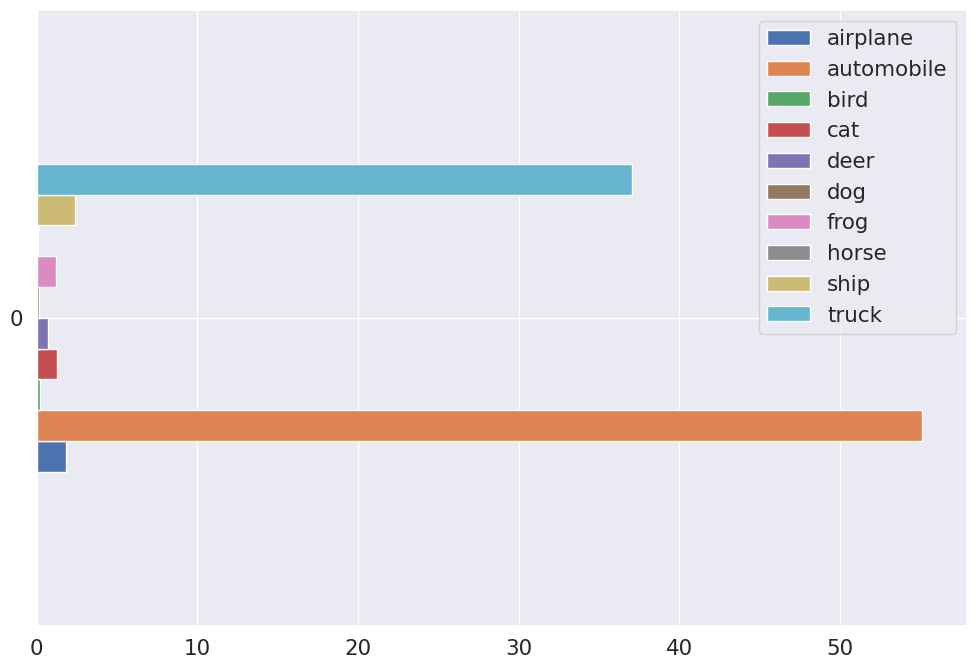

In [44]:
df_prob.plot(kind='barh', figsize=(12, 8))
